In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import time
import pyspark
import pathlib

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import when, col, to_date, date_trunc, rank, monotonically_increasing_id, date_trunc, min, max
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, LongType, DoubleType

In [10]:
spark.stop()

In [2]:
conf = pyspark.SparkConf().setAll([\
    ('spark.app.name', 'ReduceData')])
spark = SparkSession.builder.config(conf=conf)\
    .getOrCreate()

spark.version

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/01 00:48:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


'3.3.1'

# checking how many patients have no change in their target

### looking at just 1 df

In [8]:
startTime = time.time()

df = spark.read\
    .parquet("/cephfs/summary_stats/all_train_bool_updated/part-00000-673cb32c-6579-4fe7-8d84-463d25ba82db-c000.snappy.parquet")
print("row count: ", df.count())
df.printSchema()
df.show()
patIds = [i.NumId for i in df.select('NumId').distinct().collect()]
print(len(patIds))

print(time.time() - startTime)

row count:  599302
root
 |-- NumId: integer (nullable = true)
 |-- Chunk: integer (nullable = true)
 |-- ShortTermVariance: float (nullable = true)
 |-- LongTermVariance: float (nullable = true)
 |-- VarianceRatio: float (nullable = true)
 |-- SampleEntropy: float (nullable = true)
 |-- PermutationEntropy: float (nullable = true)
 |-- Mean: double (nullable = true)
 |-- StdDev: double (nullable = true)
 |-- Median: float (nullable = true)
 |-- Min: float (nullable = true)
 |-- Max: float (nullable = true)
 |-- AvgFirstDiff: double (nullable = true)
 |-- AvgSecDiff: double (nullable = true)
 |-- StdFirstDiff: double (nullable = true)
 |-- StdSecDiff: double (nullable = true)
 |-- CountAbove: long (nullable = true)
 |-- CountBelow: long (nullable = true)
 |-- TotalOutOfRange: long (nullable = true)
 |-- DiffPrevious: long (nullable = true)
 |-- target: integer (nullable = true)
 |-- Sex_Female: integer (nullable = true)
 |-- Sex_Male: integer (nullable = true)
 |-- Treatment_yes_both: in

### load in all

In [3]:
'''all CSVs of the raw data'''
allTrainPaths = [str(x) for x in list(pathlib.Path('/cephfs/summary_stats/all_train_bool_updated').glob('*.parquet')) if 'part-0000' in str(x)]
allValPaths   = [str(x) for x in list(pathlib.Path('/cephfs/summary_stats/all_val_bool_updated').glob('*.parquet')) if 'part-0000' in str(x)]
allTestPaths  = [str(x) for x in list(pathlib.Path('/cephfs/summary_stats/all_test_bool_updated').glob('*.parquet')) if 'part-0000' in str(x)]

allPaths = allTrainPaths + allValPaths + allTestPaths
# allPaths.sort()

allPaths

['/cephfs/summary_stats/all_train_bool_updated/part-00004-673cb32c-6579-4fe7-8d84-463d25ba82db-c000.snappy.parquet',
 '/cephfs/summary_stats/all_train_bool_updated/part-00001-673cb32c-6579-4fe7-8d84-463d25ba82db-c000.snappy.parquet',
 '/cephfs/summary_stats/all_train_bool_updated/part-00003-673cb32c-6579-4fe7-8d84-463d25ba82db-c000.snappy.parquet',
 '/cephfs/summary_stats/all_train_bool_updated/part-00000-673cb32c-6579-4fe7-8d84-463d25ba82db-c000.snappy.parquet',
 '/cephfs/summary_stats/all_train_bool_updated/part-00002-673cb32c-6579-4fe7-8d84-463d25ba82db-c000.snappy.parquet',
 '/cephfs/summary_stats/all_val_bool_updated/part-00000-a75612e5-0bf7-46ee-9de3-b33623299dfa-c000.snappy.parquet',
 '/cephfs/summary_stats/all_val_bool_updated/part-00001-a75612e5-0bf7-46ee-9de3-b33623299dfa-c000.snappy.parquet',
 '/cephfs/summary_stats/all_test_bool_updated/part-00001-f6d319b8-55d1-4858-9bb1-97bf18cbf6b2-c000.snappy.parquet',
 '/cephfs/summary_stats/all_test_bool_updated/part-00000-f6d319b8-55d

In [4]:
bool_updated_schema=StructType([StructField('NumId', IntegerType(),True),
                                StructField('Chunk', IntegerType(),True),
                                StructField('ShortTermVariance', FloatType(),True),
                                StructField('LongTermVariance', FloatType(),True),
                                StructField('VarianceRatio', FloatType(), True),
                                StructField('SampleEntropy', FloatType(), True),
                                StructField('PermutationEntropy', FloatType(), True),
                                StructField('Mean', DoubleType(), True),
                                StructField('StdDev', DoubleType(), True),
                                StructField('Median', FloatType(), True),
                                StructField('Min', FloatType(), True),
                                StructField('Max', FloatType(), True),
                                StructField('AvgFirstDiff', DoubleType(), True),
                                StructField('AvgSecDiff', DoubleType(), True),
                                StructField('StdFirstDiff', DoubleType(), True),
                                StructField('StdSecDiff', DoubleType(), True),
                                StructField('CountAbove', LongType(), True),
                                StructField('CountBelow', LongType(), True),
                                StructField('TotalOutOfRange', LongType(), True),
                                StructField('DiffPrevious', LongType(), True),
                                StructField('target', IntegerType(), True),
                                StructField('Sex_Female', IntegerType(), True),
                                StructField('Sex_Male', IntegerType(), True),
                                StructField('Treatment_yes_both', IntegerType(), True),
                                StructField('Treatment_yes_long_acting', IntegerType(), True),
                                StructField('Treatment_no', IntegerType(), True),
                                StructField('Treatment_yes_fast_acting', IntegerType(), True),
                                StructField('AgeGroup_50', IntegerType(), True),
                                StructField('AgeGroup_60', IntegerType(), True),
                                StructField('AgeGroup_70', IntegerType(), True),
                                StructField('AgeGroup_40', IntegerType(), True),
                                StructField('AgeGroup_30', IntegerType(), True),
                                StructField('AgeGroup_80', IntegerType(), True),
                                StructField('AgeGroup_90', IntegerType(), True),
                                StructField('AgeGroup_10', IntegerType(), True)])

In [7]:
startTime = time.time()

df = spark.read\
    .format('parquet')\
    .schema(bool_updated_schema)\
    .load(allPaths)\
    .select(col("NumId"), col("Chunk"), col("DiffPrevious"))

print(time.time() - startTime)

0.046408653259277344


In [8]:
startTime = time.time()

df.printSchema()
patIds = [i.NumId for i in df.select('NumId').distinct().collect()]
print(len(patIds), "total patients")
print("row count: ", df.count())

print("time:", time.time() - startTime)

root
 |-- NumId: integer (nullable = true)
 |-- Chunk: integer (nullable = true)
 |-- DiffPrevious: long (nullable = true)

7596 total patients
row count:  4501662
time: 0.4602675437927246


In [7]:
startTime = time.time()

counter = df.groupBy('NumId','target').count()
counter.show()

print("time:", time.time() - startTime)

+-----+------+-----+
|NumId|target|count|
+-----+------+-----+
| 7068|    -1|  173|
| 1384|     1|  230|
| 7476|    -1|  187|
| 6993|    -1|  178|
| 4825|    -1|  163|
|  492|     0|  480|
| 5373|     1|  165|
| 6062|    -1|  204|
| 7566|     1|  171|
| 4906|     0|  240|
| 1161|     1|   51|
| 6499|     1|  237|
| 6408|    -1|   58|
| 7536|     0|  181|
|  759|    -1|   69|
| 2952|    -1|  175|
| 4282|     1|  254|
| 6097|     1|  193|
| 1181|     0|  171|
| 5330|     0|  220|
+-----+------+-----+
only showing top 20 rows

time: 1.4051244258880615


In [8]:
counter = counter.orderBy("NumId", "target", ascending=True)
counter.show()

+-----+------+-----+
|NumId|target|count|
+-----+------+-----+
|    0|    -1|  201|
|    0|     0|  222|
|    0|     1|  199|
|    1|    -1|  193|
|    1|     0|  170|
|    1|     1|  205|
|    2|    -1|  144|
|    2|     0|  308|
|    2|     1|  135|
|    3|    -1|  183|
|    3|     0|  180|
|    3|     1|  183|
|    4|    -1|  109|
|    4|     0|  407|
|    4|     1|  109|
|    5|    -1|  175|
|    5|     0|  198|
|    5|     1|  173|
|    6|    -1|  193|
|    6|     0|  136|
+-----+------+-----+
only showing top 20 rows



In [9]:
pf = df.toPandas()
pf.to_csv("temptemp/df_pandas.csv",index=False)

# pandas and seaborn

In [1]:
%pip install numpy==1.23.5 pandas==1.5.3 seaborn
%pip install -U matplotlib

  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached contourpy-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached Pillow-9.5.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.4 MB)
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached fonttools-4.39.4-py3-none-any.whl (1.0 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pf = pd.read_csv("temptemp/df_pandas.csv")
pf

,NumId,Chunk,DiffPrevious
0,83,1,-2
1,83,11,2
2,83,14,-37
3,83,17,0
4,83,19,36
...,...,...,...
4501657,7388,286,48
4501658,7388,289,-33
4501659,7388,292,38
4501660,7388,293,-12


In [3]:
pf[['NumId','DiffPrevious']].groupby('NumId').std().head(20)

,DiffPrevious
NumId,
0,21.928432
1,28.087876
2,18.737008
3,29.033918
4,12.271611
5,34.367892
6,34.465841
7,18.928757
8,23.965114


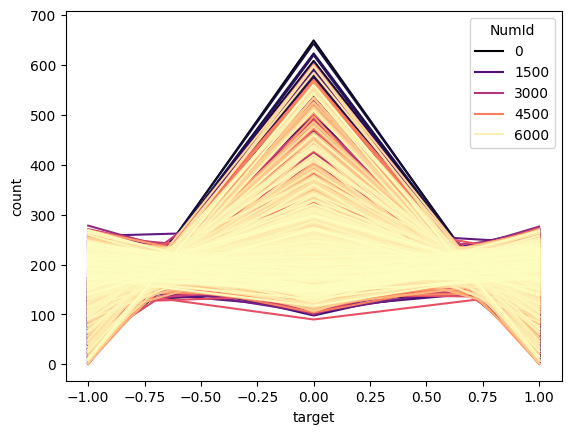

In [11]:
sns.lineplot(data=pf.loc[:18000], x='target', y='count', hue='NumId', palette="magma")
plt.show()

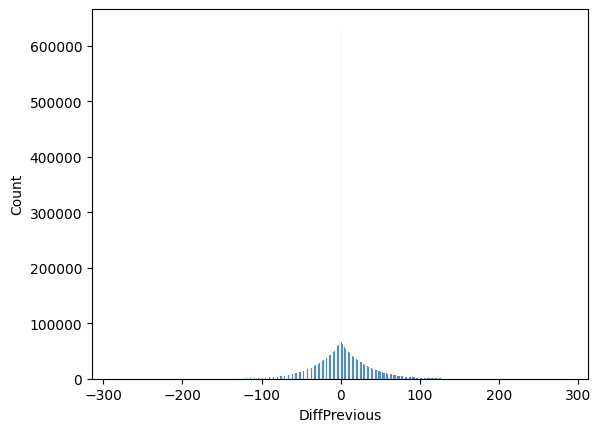

In [5]:
sns.histplot(data=pf, x='DiffPrevious')
plt.show()

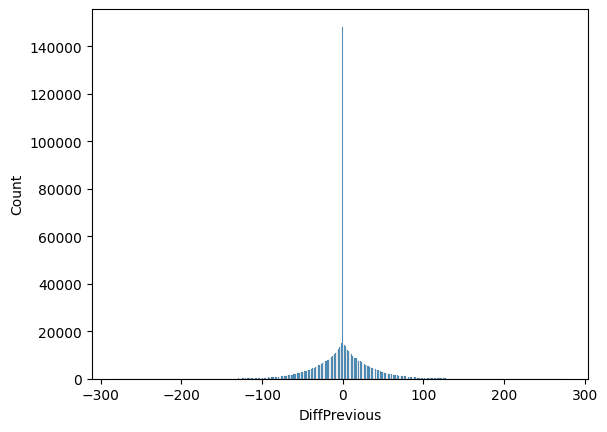

In [7]:
sns.histplot(data=pf.loc[:1000000], x='DiffPrevious')
plt.show()

In [13]:
buffer = 9
pf[(pf['DiffPrevious']<=buffer) & (pf['DiffPrevious']>=-buffer)].shape

(1657315, 3)

In [ ]:
pf.shape

In [1]:
%cp -r "/cephfs/Saved_Models/Hyperparameter_Tuning/XGBClassification1/stages/2_CrossValidatorModel_ed83c0dad113/metadata/part-00000" "temp_file.json"